**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

** Import the neccessary modules and data **

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pickle
import cv2
import glob
from sklearn.preprocessing import StandardScaler
from importlib import reload
from sln import utils; reload(utils)
from sln import train; reload(train)
from sln import search; reload(search)

<module 'sln.search' from 'D:\\side\\CarND-Vehicle-Detection\\sln\\search.py'>

In [2]:
svc_pickle = pickle.load( open("svc.p", "rb" ))
svc = svc_pickle['svc']
scaler = svc_pickle['scaler']

### Histogram of Oriented Gradients (HOG)

#### Explain how (and identify where in your code) you extracted HOG features from the training images.

The code I extract HOG features is contained in [`./sln/train.py`](./sln/train.py), the function `get_hog_features` (line 6-16). 

I use the same parameters as the following example:

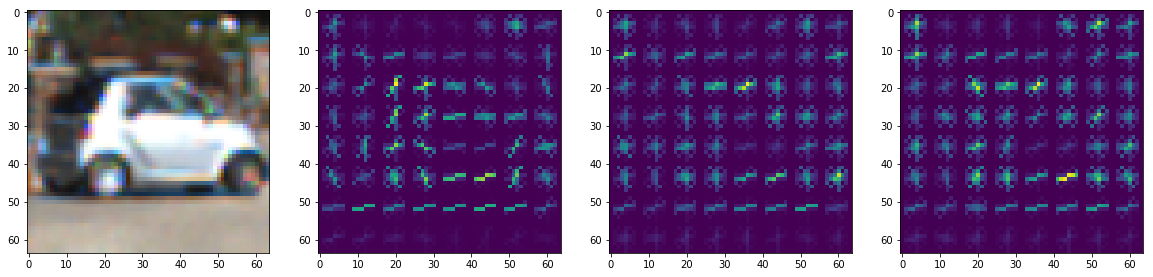

In [22]:
images = glob.glob('data/vehicles/*/*.png')
img = cv2.imread(images[np.random.randint(len(images))])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_feat1, hog1_vis = train.get_hog_features(YCrCb[...,0], orient, pix_per_cell, cell_per_block, True)
hog_feat2, hog2_vis = train.get_hog_features(YCrCb[...,1], orient, pix_per_cell, cell_per_block, True)
hog_feat3, hog3_vis = train.get_hog_features(YCrCb[...,2], orient, pix_per_cell, cell_per_block, True) 
plt.figure(figsize=(20,8))
plt.subplot(141)
plt.imshow(img)
plt.subplot(142)
plt.imshow(hog1_vis)
plt.subplot(143)
plt.imshow(hog2_vis)
plt.subplot(144)
plt.imshow(hog3_vis)

#### Explain how you settled on your final choice of HOG parameters

After some experiments the color space used is **YCrCb** same as in the course since it does improve the training accuracy (see below).

#### Classifer

I trained a linear SVG using the feature vector combined with binned color, histograms of color and from YCrCb extacted vector.

The feature vector is normalized using `sklearn.preprocessing.StandardScaler`.

The training code is noted in the Jupyter notebook [`train.ipynb`](./train.ipynb).

The classifier is able to score `0.9909` on the test set.

#### Sliding Window Search

The sliding search is implemented in [`./sln/search.py`](./sln/search.py), the function `find_cars` (line 5-57). It returns a set of bounding boxes by predict the position where vehicles could be located.

To improve the efficiency of the efficiency of the detection and tracking, the __HOG__ features at prediction time were taken once against an ROI of the image, rather than on independent windows.

I have tried different scale for the window. The scale beginning at 1.3 yields a satisfying result in the test image.

An example:

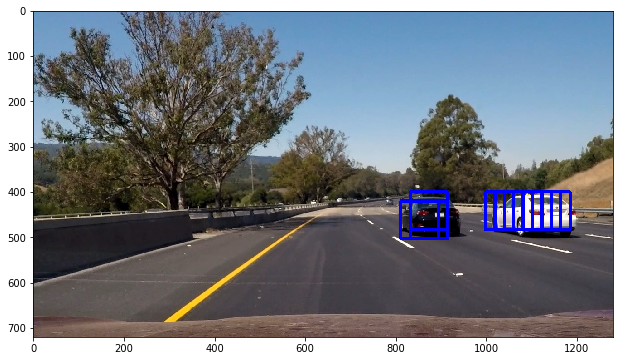

In [47]:
ystart = 400
ystop = 656
orient = 9
pix_per_cell = 8
cell_per_block = 2
scale = 1.3

img = mpimg.imread('test_images/test6.jpg')
bboxes = search.find_cars(img, svc, scaler, 
                          ystart, ystop, orient, pix_per_cell, cell_per_block, scale)
draw_img = search.draw_bboxes(img, bboxes)
plt.figure(figsize=(20,6))
plt.imshow(draw_img)

I threshold the heatmap to discard the false positives.

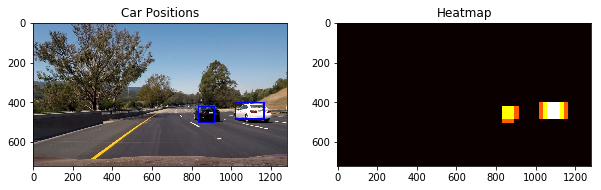

In [41]:
draw_img, heatmap = search.draw_result(img, bboxes, threshold=1, output_heatmap=True)
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap')

#### Video Implementation

[`Link to video result`](output_video.mp4)

In the video processing pipeline I used a multipl-scale sliding window (`sln/search.py` line 117-124) at scales `[1.3, 1,6, 2, 2.5, 3, 5, 7]`.

All bounding boxes predicted from the last three frames are collected to generate a heapmap for current frame. This heapmap is thresholded against the being used scales plus 1.

#### Discussion

There are still false positives in the video. It often fails at the region with complex texture. I consider training a classifer with a different dataset, refering more previous frames in the video pipeline, or trying the convolutional neural networks approach.